In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def DisplayConfusionMatrix(actual, prediction):
    cm = confusion_matrix(actual, prediction)
    cm_dspl = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_dspl.plot(cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
xtrain = pd.read_csv('xtrain.csv')
xtest = pd.read_csv('xtest.csv')
ytrain = pd.read_csv('ytrain.csv')
ytest = pd.read_csv('ytest.csv')
xtrain.shape, xtest.shape,  ytrain.shape, ytest.shape

((228910, 165), (97828, 165), (228910, 1), (97828, 1))

In [4]:
f5 = RFE(estimator=LGBMClassifier(), n_features_to_select=50, step=1)
pipeline = Pipeline([
    ('rfe_feature_selection', f5),
    ('clf', LGBMClassifier())
    ])
pipeline.fit(xtrain, ytrain)

Pipeline(steps=[('rfe_feature_selection',
                 RFE(estimator=LGBMClassifier(), n_features_to_select=50)),
                ('clf', LGBMClassifier())])

In [5]:
support = pipeline.named_steps['rfe_feature_selection'].support_

In [6]:
feature_names = np.array(xtrain.columns) # transformed list to array
xtrain = xtrain[feature_names[support]]
xtest = xtest[feature_names[support]]

In [7]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((228910, 50), (97828, 50), (228910, 1), (97828, 1))

In [8]:
xtrain = xtrain.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
xtest = xtest.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
y_train = np.array(ytrain.DEP_DEL15)
y_test = np.array(ytest.DEP_DEL15)

In [9]:
nb = BernoulliNB()
nbmodel = nb.fit(xtrain, y_train)
lgbm = LGBMClassifier()
lgbmodel = lgbm.fit(xtrain, y_train)
xgc = XGBClassifier()
xgcmodel = xgc.fit(xtrain, y_train)

In [10]:
param_grid = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
              'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
              'n_estimators': list(np.arange(50, 251)),
              'random_state': list(np.arange(0, 101)),
              'reg_alpha': list(np.arange(0.1, 1.1, 0.1)),
              'reg_lambda': list(np.arange(0.1, 1.1, 0.1))}

In [11]:
cv = RandomizedSearchCV(estimator=lgbmodel, param_distributions=param_grid,
                        random_state=42)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

{'reg_lambda': 0.4,
 'reg_alpha': 0.9,
 'random_state': 93,
 'n_estimators': 166,
 'learning_rate': 0.6,
 'boosting_type': 'dart'}

Training accuracy 0.8864
Testing accuracy 0.8800
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     48914
           1       0.98      0.77      0.87     48914

    accuracy                           0.88     97828
   macro avg       0.90      0.88      0.88     97828
weighted avg       0.90      0.88      0.88     97828



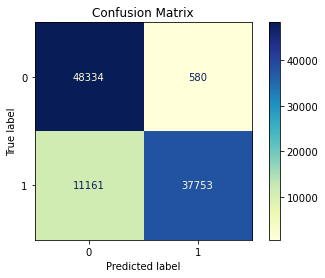

In [12]:
lgbm = LGBMClassifier(boosting_type=bp['boosting_type'],
                      learning_rate=bp['learning_rate'],
                      n_estimators=bp['n_estimators'],
                      random_state=bp['random_state'],
                      reg_alpha=bp['reg_alpha'],
                      reg_lambda=bp['reg_lambda'])
lgbmodel = lgbm.fit(xtrain, y_train)
y_pred = lgbmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(lgbmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(lgbmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)

In [13]:
param_grid = {'alpha': list(np.arange(0.01, 1.01, 0.01)),
              'fit_prior': [True, False]}

In [14]:
cv = RandomizedSearchCV(estimator=nbmodel, param_distributions=param_grid,
                        n_jobs=-1, random_state=42)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

{'fit_prior': False, 'alpha': 0.48000000000000004}

Training accuracy 0.8081
Testing accuracy 0.8072
              precision    recall  f1-score   support

           0       0.78      0.86      0.82     48914
           1       0.84      0.75      0.80     48914

    accuracy                           0.81     97828
   macro avg       0.81      0.81      0.81     97828
weighted avg       0.81      0.81      0.81     97828



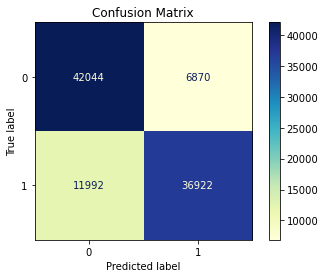

In [15]:
nb = BernoulliNB(alpha=bp['alpha'], fit_prior=bp['fit_prior'])
nbmodel = nb.fit(xtrain, y_train)
y_pred = nbmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(nbmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(nbmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)

In [16]:
param_grid = {'booster': ['gbtree', 'gblinear', 'dart'],
              'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
              'max_depth': [0],
              'sampling_method': ['uniform', 'gradient_based'],
              'reg_alpha': list(np.arange(0.1, 1.1, 0.1)),
              'reg_lambda': list(np.arange(0.1, 1.1, 0.1))}

In [17]:
cv = RandomizedSearchCV(estimator=xgcmodel, param_distributions=param_grid,
                        n_jobs=-1)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

[09:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




{'sampling_method': 'gradient_based',
 'reg_lambda': 0.30000000000000004,
 'reg_alpha': 0.1,
 'max_depth': 0,
 'learning_rate': 0.8,
 'booster': 'gblinear'}

[09:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_depth", "sampling_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training accuracy 0.5056
Testing accuracy 0.4918
              precision    recall  f1-score   support

           0       0.49      0.48      0.49     48914
           1       0.49      0.50      0.50     48914

    accuracy                           0.49     97828
   macro avg       0.49      0.49      0.49     97828
weighted avg       0.49      0.49      0.49     97828



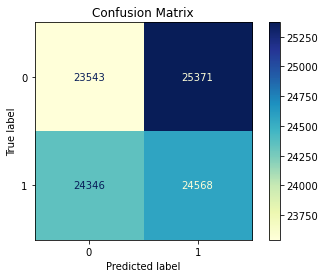

In [18]:
xgc = XGBClassifier(booster=bp['booster'], learning_rate=bp['learning_rate'],
                    max_depth=0, sampling_method=bp['sampling_method'],
                    reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'])
xgcmodel = xgc.fit(xtrain, y_train)
y_pred = xgcmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(xgcmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(xgcmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)

In [25]:
param_grid = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
              'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
              'reg_alpha': list(np.arange(0.1, 1.1, 0.1)),
              'reg_lambda': list(np.arange(0.1, 1.1, 0.1))}

In [ ]:
cv = GridSearchCV(estimator=lgbmodel, param_grid=param_grid, n_jobs=-1)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

In [ ]:
nb = BernoulliNB()
nbmodel = nb.fit(xtrain, y_train)
lgbm = LGBMClassifier()
lgbmodel = lgbm.fit(xtrain, y_train)
xgc = XGBClassifier()
xgcmodel = xgc.fit(xtrain, y_train)

In [ ]:
lgbm = LGBMClassifier(boosting_type=bp['boosting_type'],
                      learning_rate=bp['learning_rate'],
                      reg_alpha=bp['reg_alpha'],
                      reg_lambda=bp['reg_lambda'])
lgbmodel = lgbm.fit(xtrain, y_train)
y_pred = lgbmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(lgbmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(lgbmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)

In [ ]:
param_grid = {'alpha': list(np.arange(0, 1.01, 0.01)),
              'fit_prior': [True, False]}

In [ ]:
cv = GridSearchCV(estimator=nbmodel, param_grid=param_grid,
                  n_jobs=-1)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

In [ ]:
nb = BernoulliNB(alpha=bp['alpha'], fit_prior=bp['fit_prior'])
nbmodel = nb.fit(xtrain, y_train)
y_pred = nbmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(nbmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(nbmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)

In [ ]:
param_grid = {'booster': ['gbtree', 'gblinear', 'dart'],
              'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
              'sampling_method': ['uniform', 'gradient_based'],
              'reg_alpha': list(np.arange(0.1, 1.1, 0.1)),
              'reg_lambda': list(np.arange(0.1, 1.1, 0.1))}

In [ ]:
cv = GridSearchCV(estimator=xgcmodel, param_grid=param_grid,
                  n_jobs=-1)
cv.fit(xtrain, y_train)
bp = cv.best_params_
bp

In [ ]:
xgc = XGBClassifier(booster=bp['booster'], learning_rate=bp['learning_rate'],
                    max_depth=0, sampling_method=bp['sampling_method'],
                    reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'])
xgcmodel = xgc.fit(xtrain, y_train)
y_pred = xgcmodel.predict(xtest)
print('Training accuracy {:.4f}'.format(xgcmodel.score(xtrain, y_train)))
print('Testing accuracy {:.4f}'.format(xgcmodel.score(xtest, y_test)))
print(classification_report(y_test, y_pred))
DisplayConfusionMatrix(y_test, y_pred)